In [13]:
import os
import pandas as pd
import numpy as np
import rasterio
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Load the images

In [14]:
def load_data(paths):
    # Get a list of all files in the directory (X_train, y_train, X_test)
    file_list = [[file for file in os.listdir(paths) if file.endswith('.tif')] for paths in directory_paths]

    # Sort the file list to ensure consistent order
    file_list = [sorted(files) for files in file_list]

    # Initialize an empty array to store the image data
    X_train, y_train, X_test = [], [], []

    # Iterate through the selected files
    for X_train_name, y_train_name in tqdm(zip(file_list[0], file_list[1])):
        # Construct the full path to the file
        X_train_path = os.path.join(paths[0], X_train_name)
        y_train_path = os.path.join(paths[1], y_train_name)

        # Open the raster file using rasterio
        with rasterio.open(X_train_path) as src:
            # Read the entire image data as a NumPy array
            image_data = src.read()

            # Append the image data to the array
            X_train.append(image_data)

        # Open the raster file using rasterio
        with rasterio.open(y_train_path) as src:
            # Read the entire image data as a NumPy array
            image_data = src.read()

            # Append the image data to the array
            y_train.append(image_data)

    # Convert the list of arrays to a single NumPy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    return X_train, y_train



In [15]:
directory_paths = ['../data/raw/train_satellite', '../data/raw/train_kelp']
os.path.abspath(directory_paths[0])
X_train, y_train = load_data(directory_paths)

print("Shape of the X_train array:", X_train.shape)
print("Shape of the y_train array:", y_train.shape)

0it [00:00, ?it/s]

C:\Users\EmielW\Epoch\Competitions\q2-detect-kelp\venv\Lib\site-packages\rasterio\__init__.py:317: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Shape of the X_train array: (5634, 7, 350, 350)
Shape of the y_train array: (5634, 1, 350, 350)


# Create a dataframe
Convert the data to a column format, this loses spatial information, but makes it easier to work with.
Features are computed during the conversion, so it is possible to use spatial information in the features.

In [16]:
import scipy


def reshape(img: np.ndarray):
    img = img.transpose(1,2,0)
    img = img.reshape(-1,img.shape[2])
    return img

def to_df(img: np.ndarray, label: np.ndarray):
    
    # Create a dataframe with the base features
    df = pd.DataFrame(reshape(img), columns=['SWIR','NIR', 'R', 'G', 'B','Cloud','Elevation'])
    df['Water'] = df['Elevation'] < 1
    
    df['NDWI'] = (df['G'] - df['NIR']) / (df['G'] + df['NIR'])
    df['MNDWI'] = (df['G'] - df['SWIR']) / (df['G'] + df['SWIR'])
    df['NDVI'] = (df['NIR'] - df['R']) / (df['NIR'] + df['R'])
    
    # Land closeness, roughly inverse distance to land
    land_dist = scipy.ndimage.distance_transform_edt(img[6, :, :] <= 0)
    land_closeness = 1 / (1 + land_dist * 0.1)
    df['LandCloseness'] = land_closeness.flatten()
    
    # Offset features, using difference with median of all water pixels
    if df['Water'].sum() > 0:
        df['ONIR'] = df['NIR'] - df[df['Water']]['NIR'].median() 
        
        ROffset = df['R'] - df[df['Water']]['R'].median()
        GOffset = df['G'] - df[df['Water']]['G'].median()
        df['ODWI'] = (GOffset - df['ONIR'])
        df['ODVI'] = (df['ONIR'] - ROffset)
    else:
        df['ONIR'] = 0
        df['ODWI'] = 0
        df['ODVI'] = 0
        
    
    # Add the label to the dataframe
    df['Label'] = label.flatten()
    return df

In [17]:
# concatenate the first N images
num = 3000
df = pd.concat([to_df(X_train[i], y_train[i]) for i in tqdm(range(num))])

  0%|          | 0/3000 [00:00<?, ?it/s]

# Visualise the feature distributions

  0%|          | 0/16 [00:00<?, ?it/s]

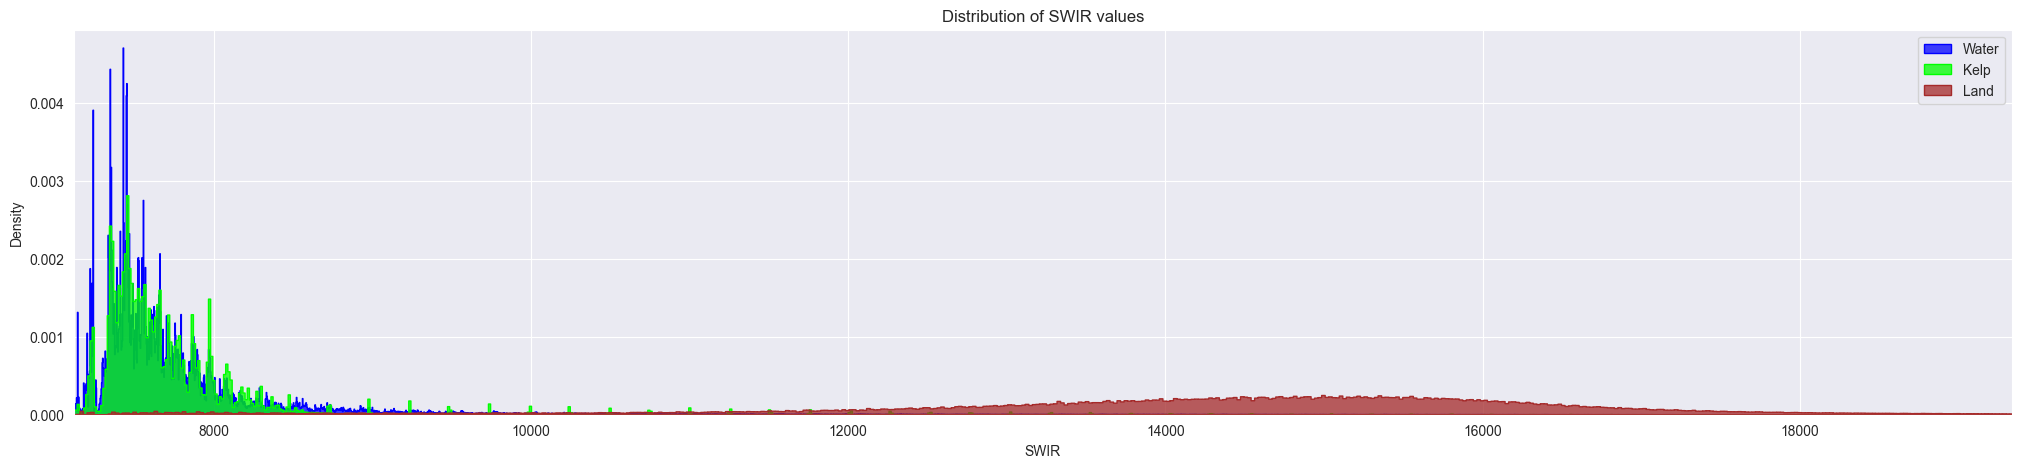

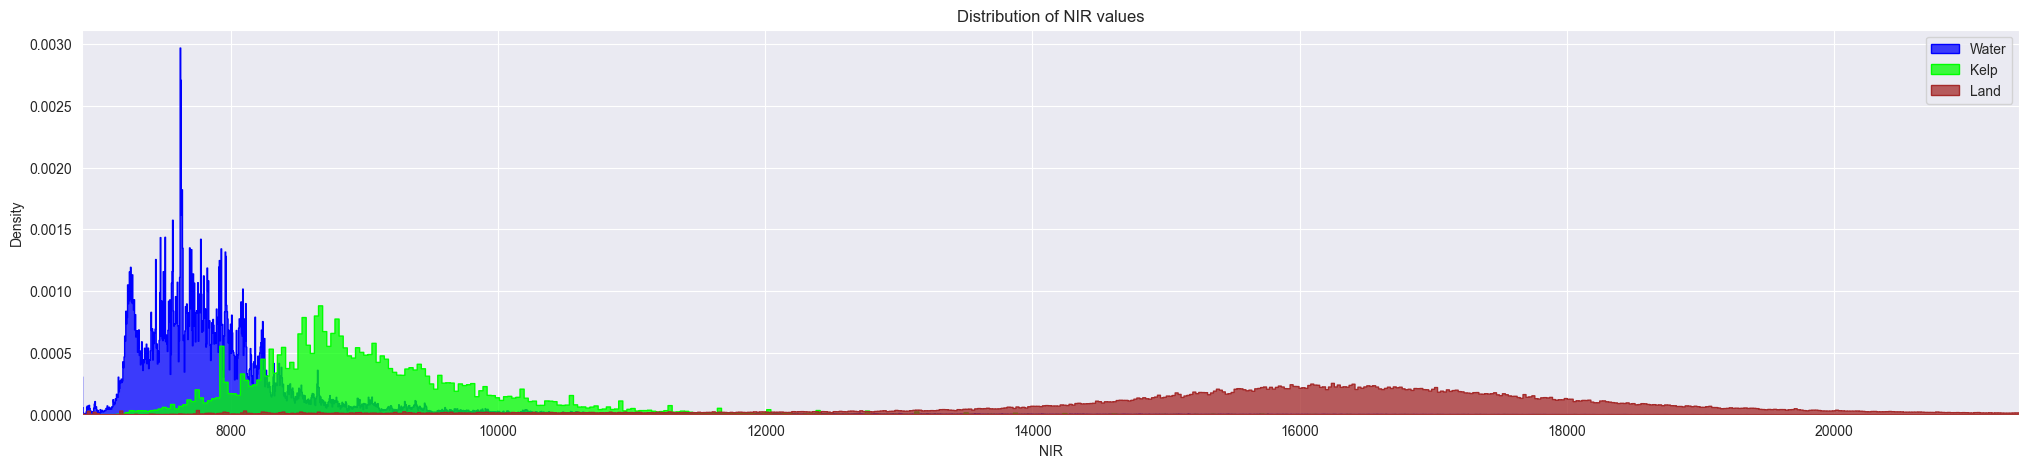

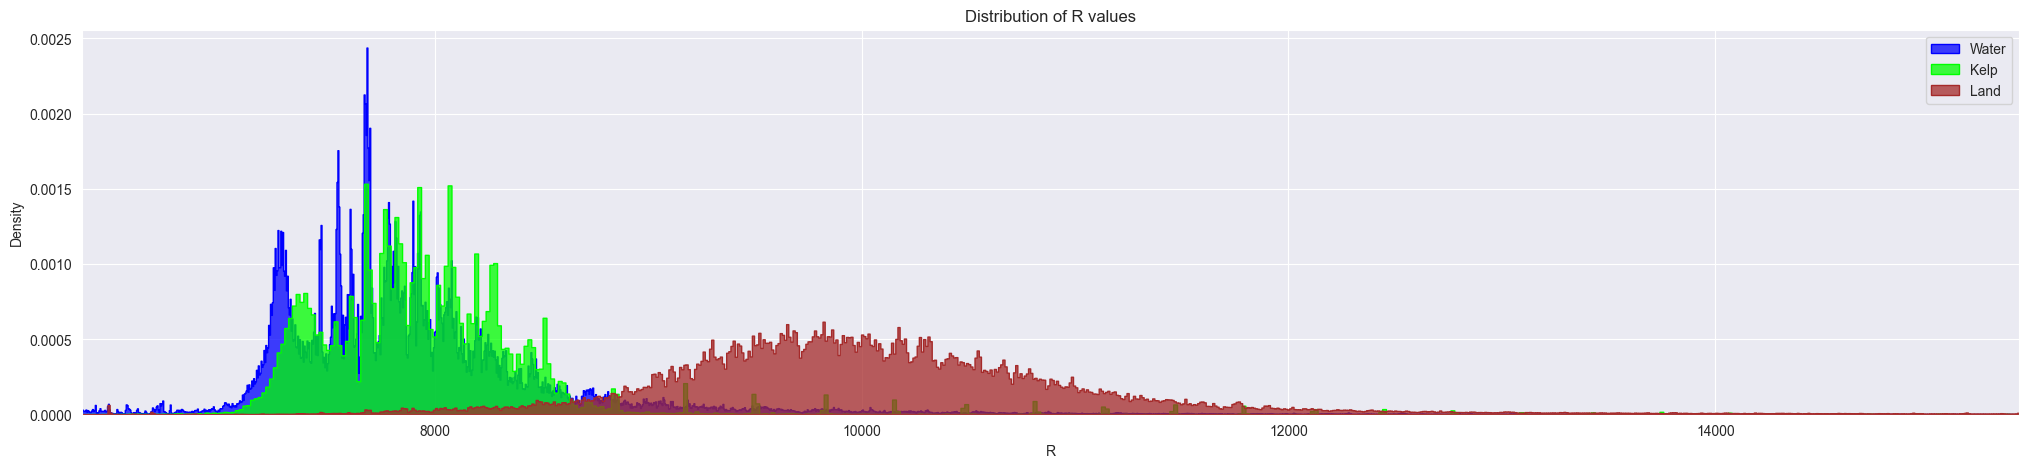

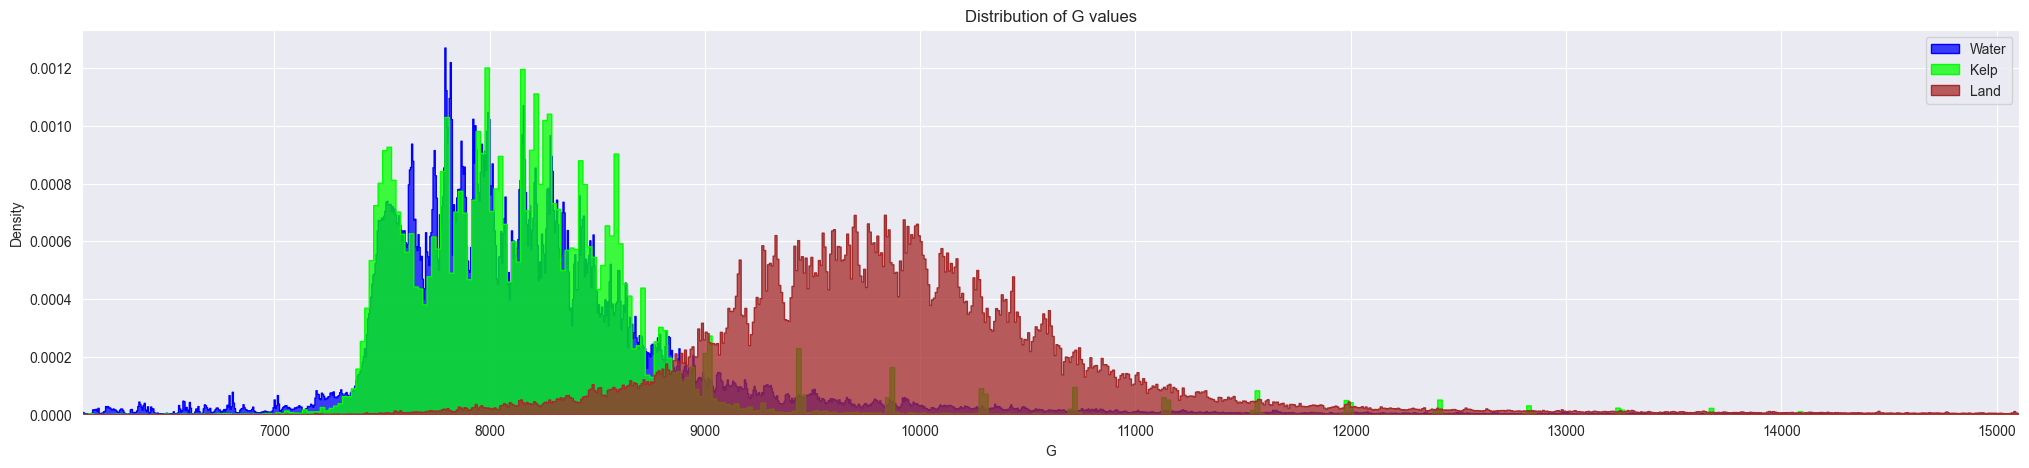

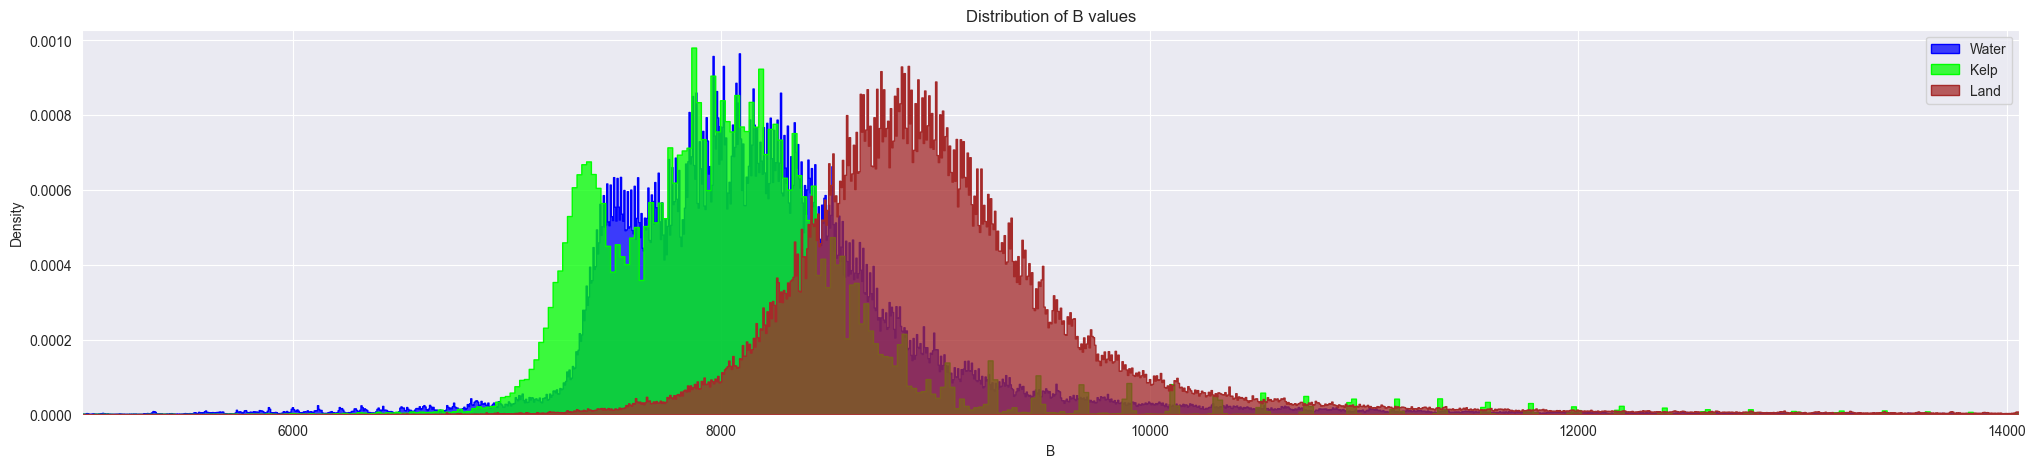

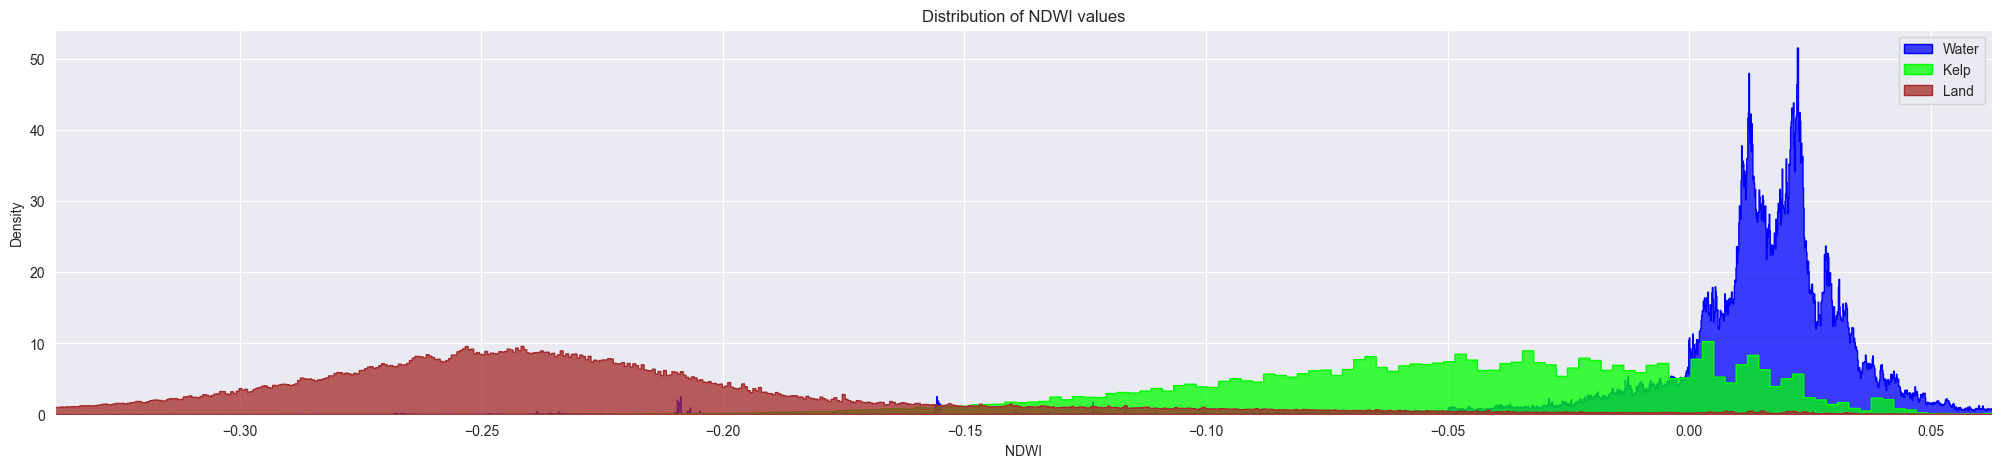

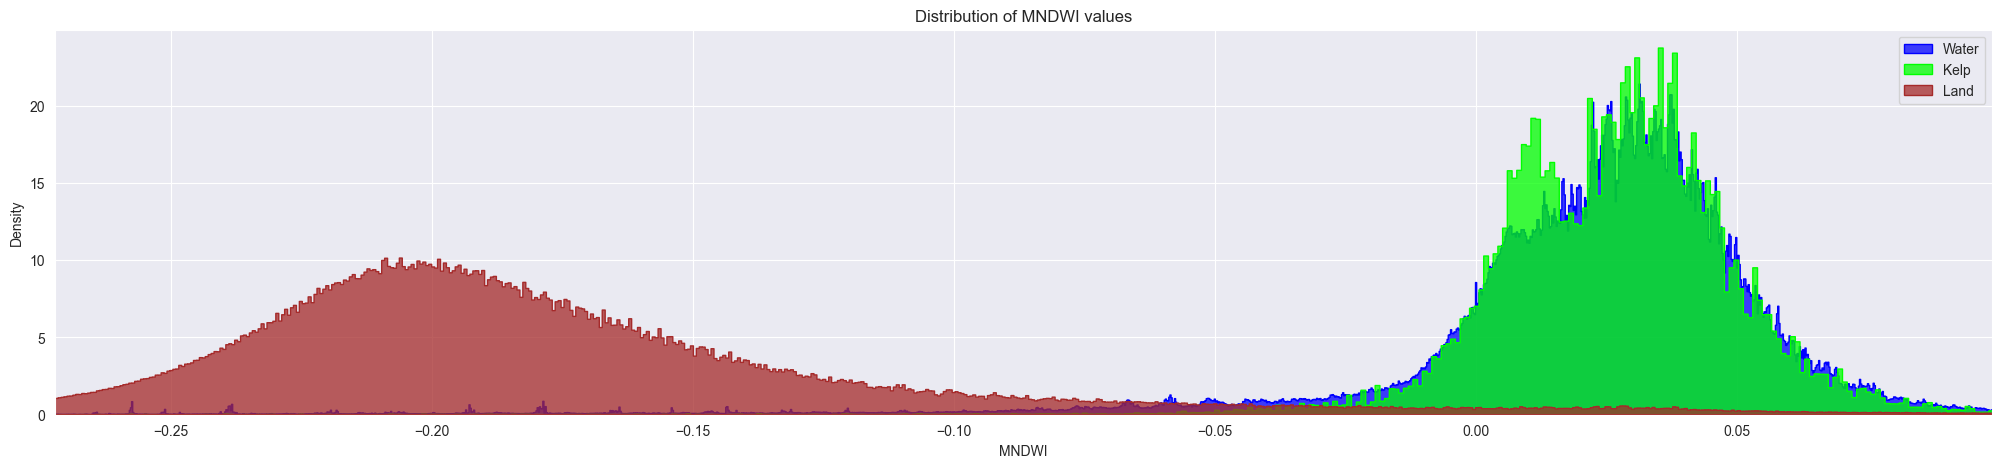

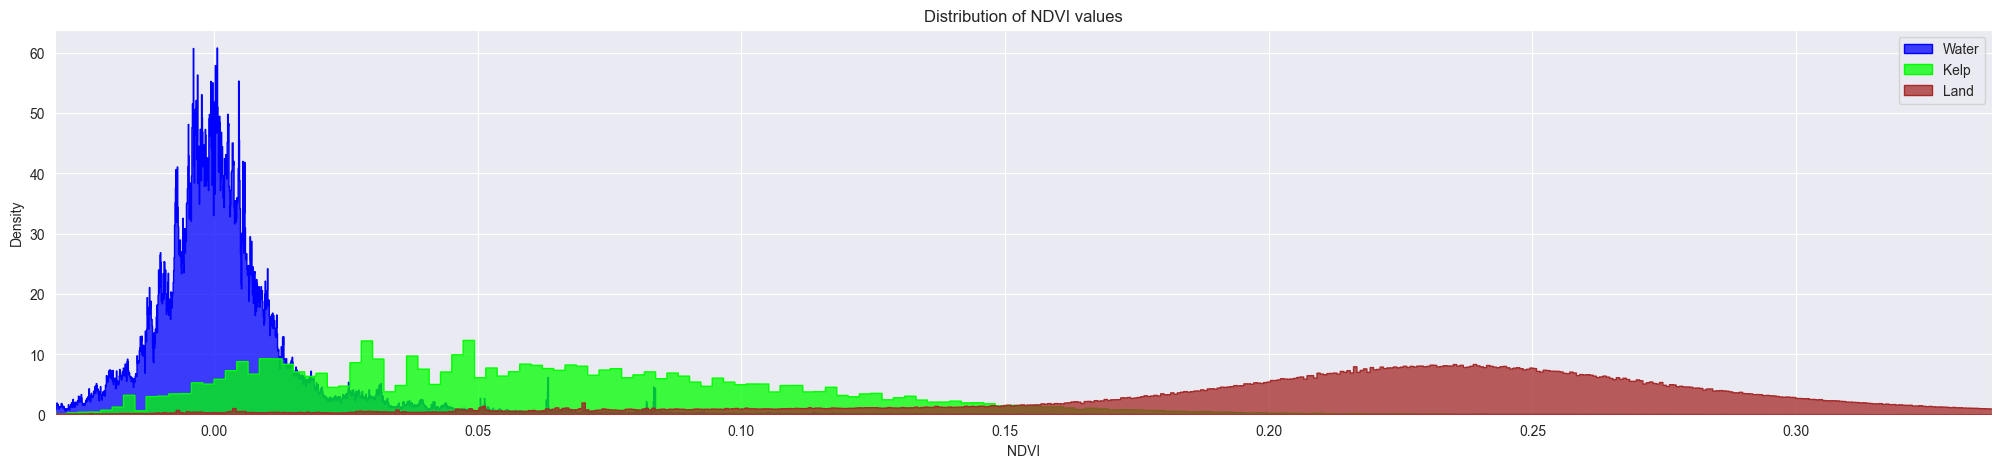

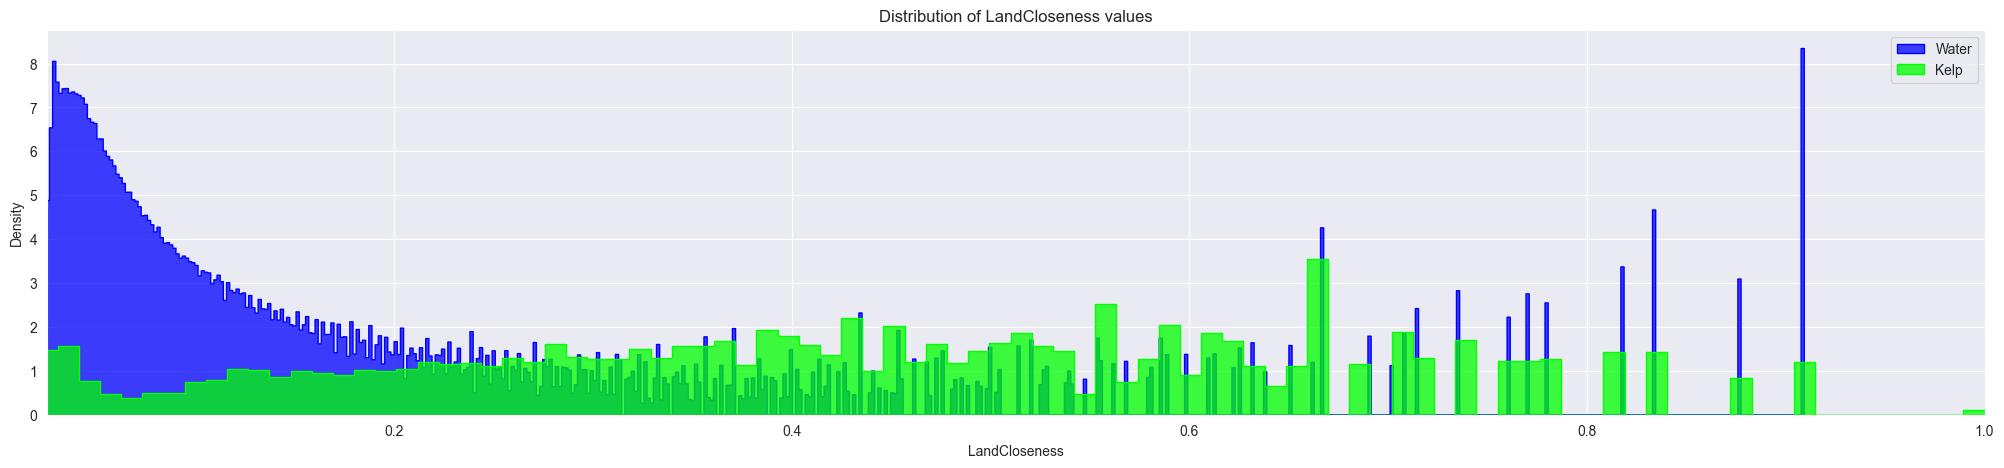

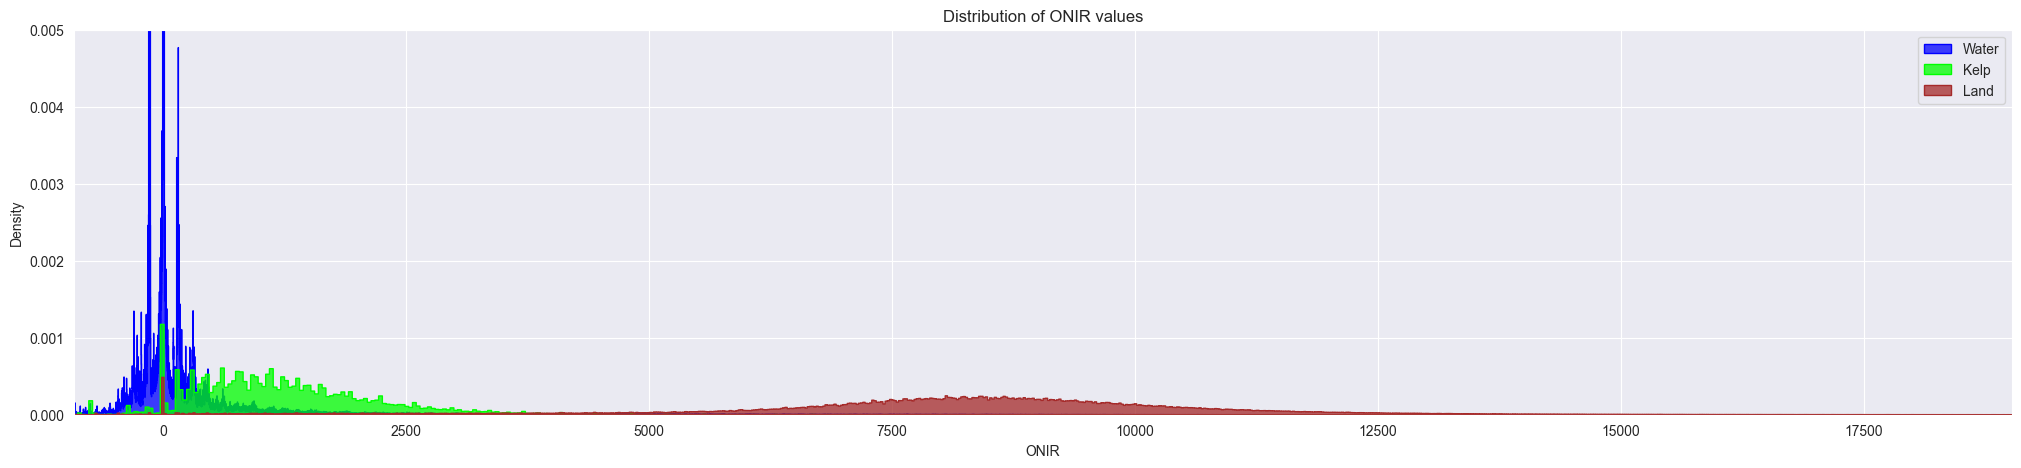

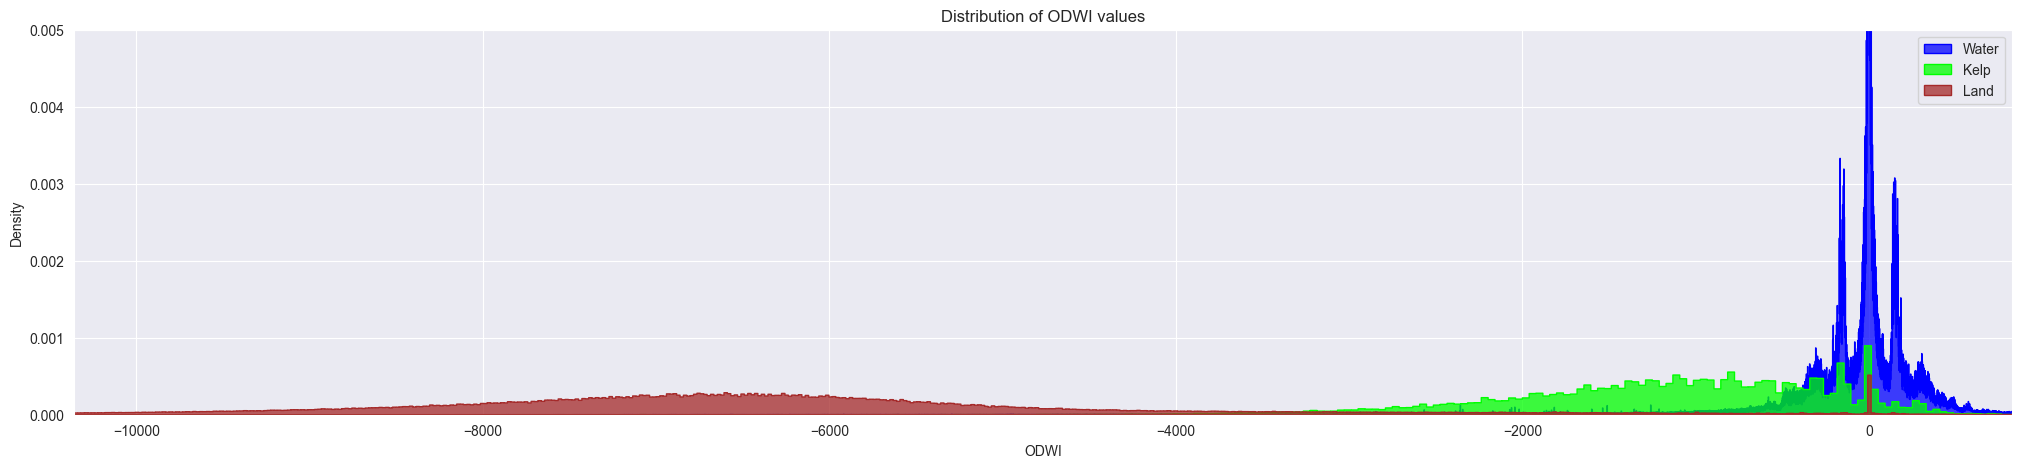

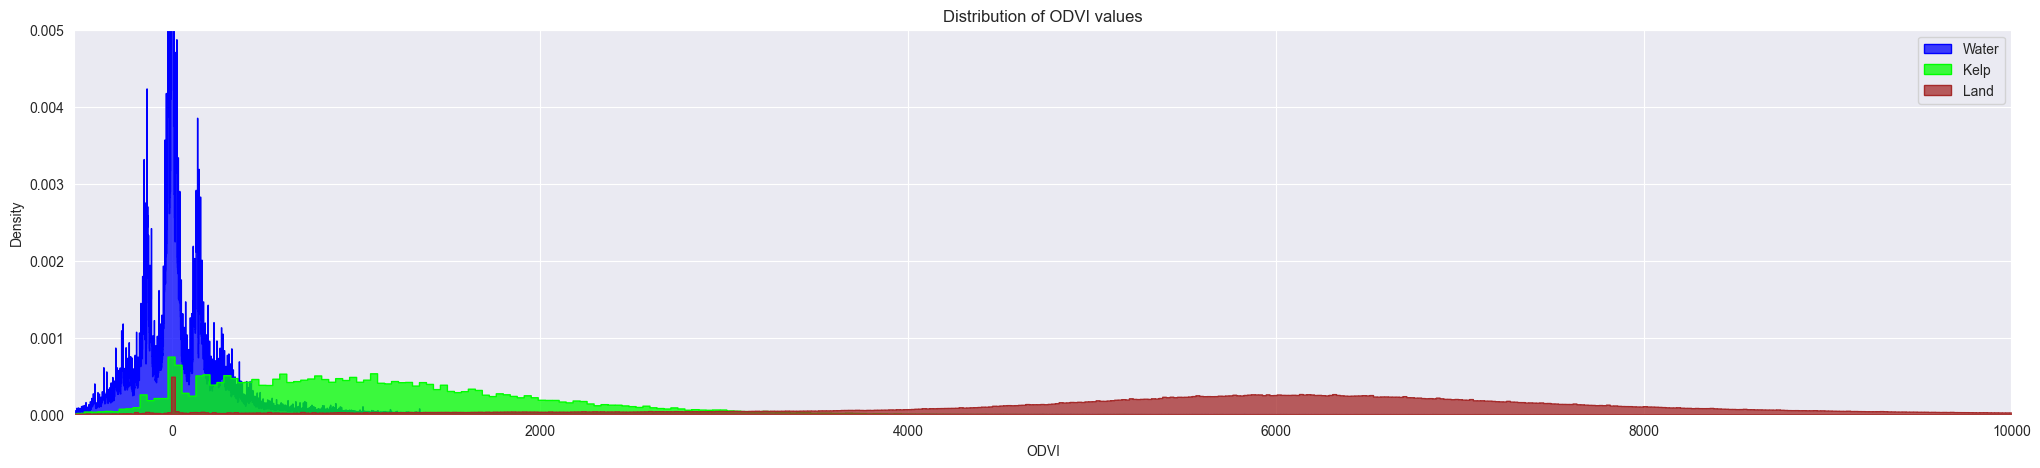

In [18]:
# For each feature plot the distribution of values for water, kelp and land
for feature in tqdm(df.columns):
    if feature in ['Cloud', 'Elevation','Water','Label']:
        continue
    
    # subsample and filter on water pixels without missing values
    dfs = df[::50]
    dfs = dfs[(dfs['R']>=0) & (dfs['G']>=0) & (dfs['B']>=0) & (dfs['NIR']>=0) & (dfs['SWIR']>=0)]
    
    # Create a figure and axes
    fig, ax = plt.subplots(figsize=(25, 5))
    
    # set the x-axis limits to percentiles 1 and 99
    ax.set_xlim(dfs[feature].quantile(0.01), dfs[feature].quantile(0.99))
    
    # Plot the kde for water pixels
    water = dfs[(dfs['Water'] == 1) & ~dfs['Label']][feature]
    sns.histplot(water, label='Water', ax=ax, color='blue', element="step", stat='density')
    
    # Plot the kde for kelp pixels
    kelp = dfs[dfs['Label'] == 1][feature]
    sns.histplot(kelp, label='Kelp', ax=ax, color='lime',  element="step", stat='density')
    
    if feature != 'LandCloseness':
        # Plot the kde for land pixels
        land = dfs[dfs['Water'] == 0][feature]
        sns.histplot(land, label='Land', ax=ax, color='brown',  element="step", stat='density') 
    
    # If this is an offset feature, there will be a very large spike at zero for water, so clip the y-axis
    if feature.startswith('O'):
        ax.set_ylim(0, 0.005)

    # Set the title and display the figure for this feature
    ax.set_title(f'Distribution of {feature} values')
    plt.legend()
    plt.show()


In [19]:
print(f"Percentage of kelp on land: {df[df['Water']]['Label'].mean()}")

Percentage of kelp on land: 0.009804316147298469


From now on, we will only use the water pixels, since the amount of kelp on land is negligible for our purposes.
The distinction then has to be made between water and kelp. The feature distributions are computed separately for both, and the conditional probability P(Kelp|X) is added to the plot.

  0%|          | 0/16 [00:00<?, ?it/s]

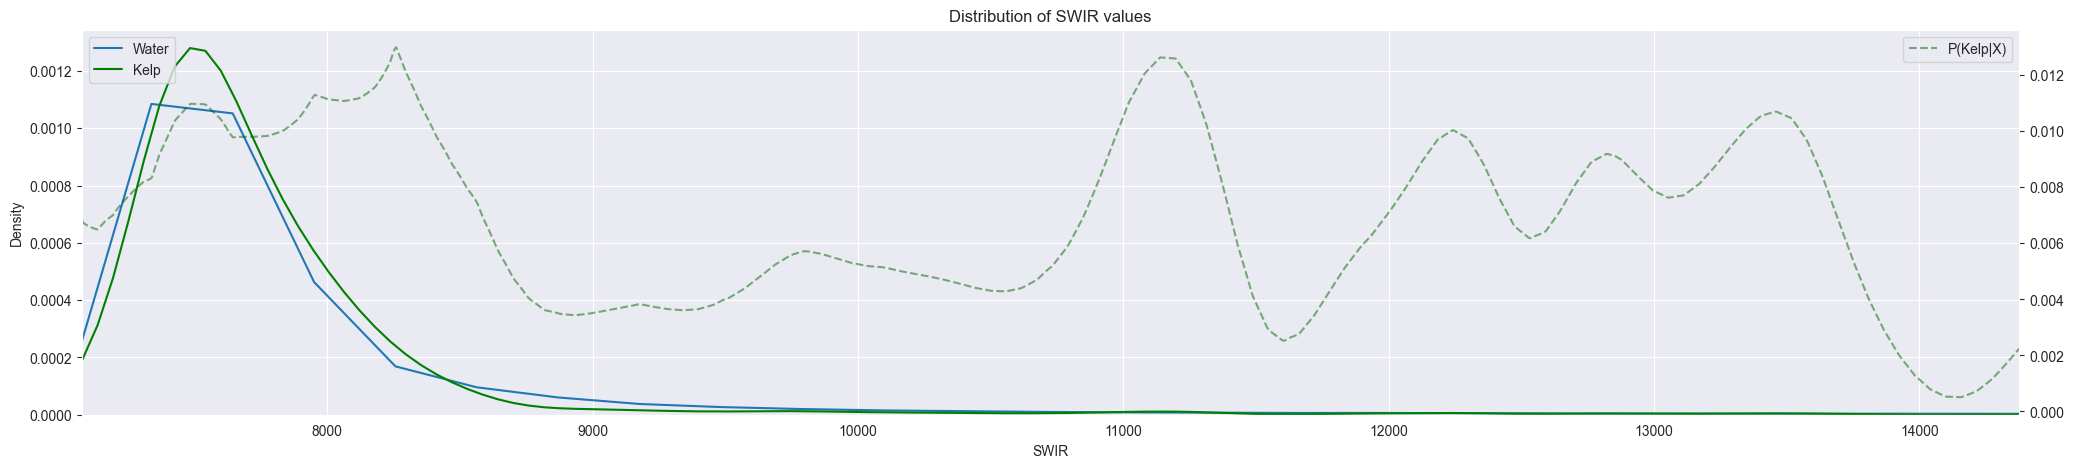

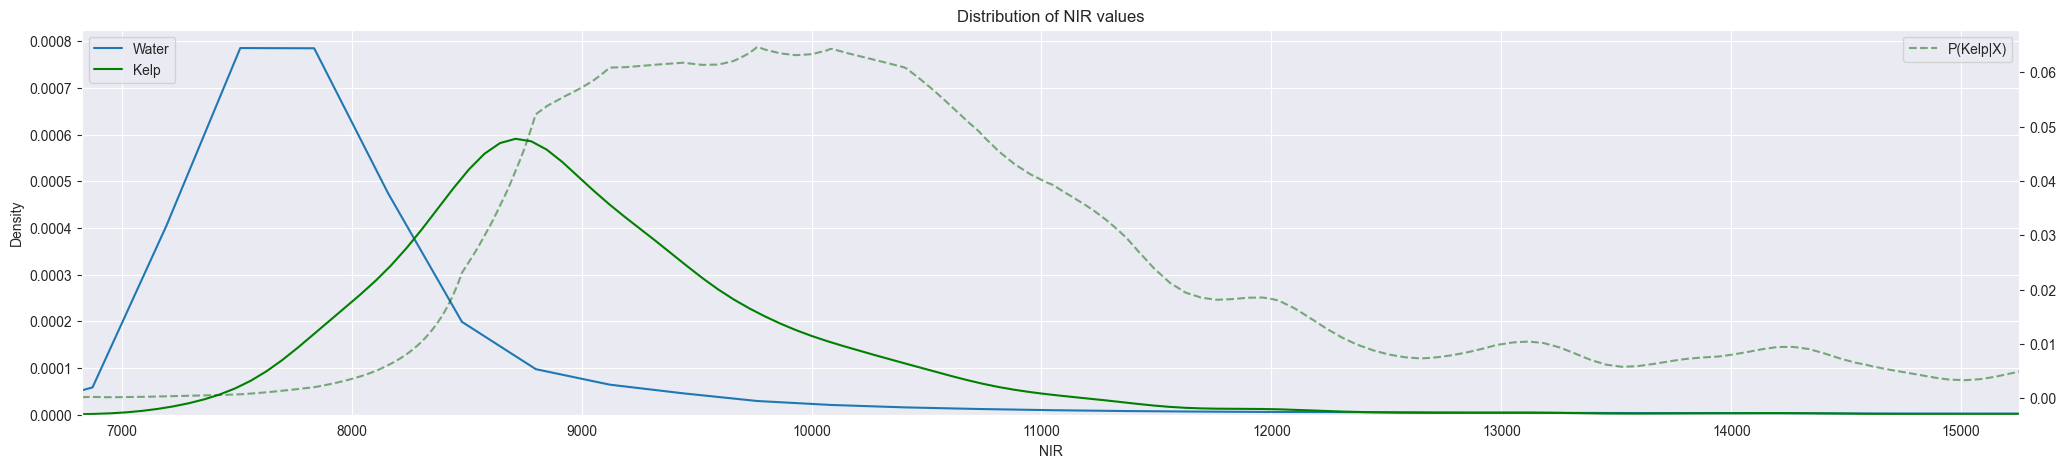

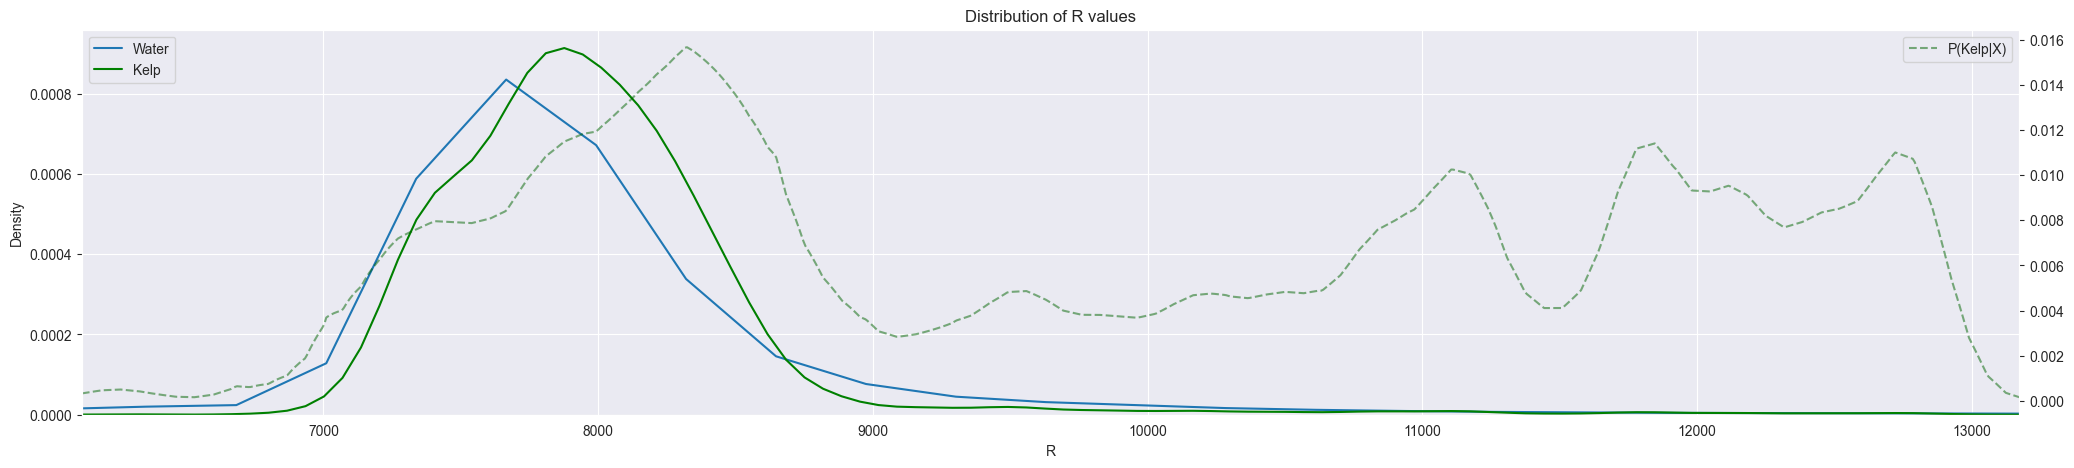

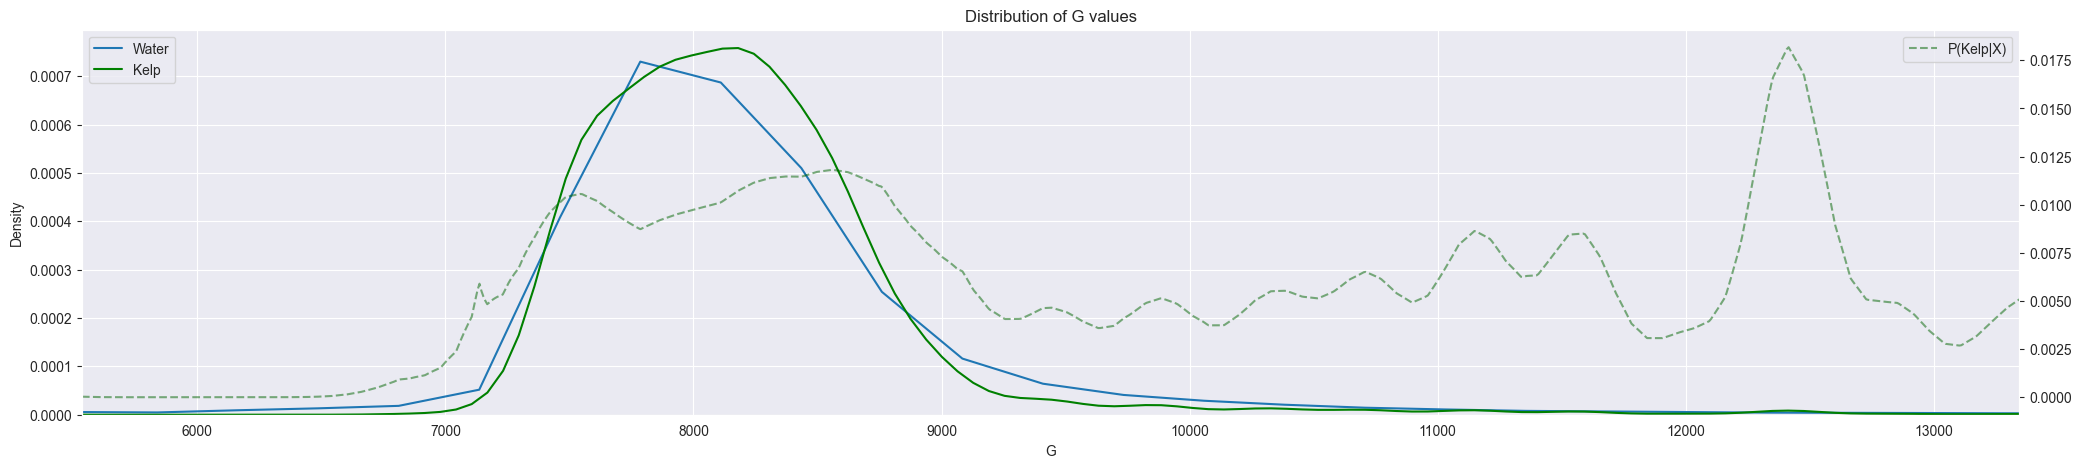

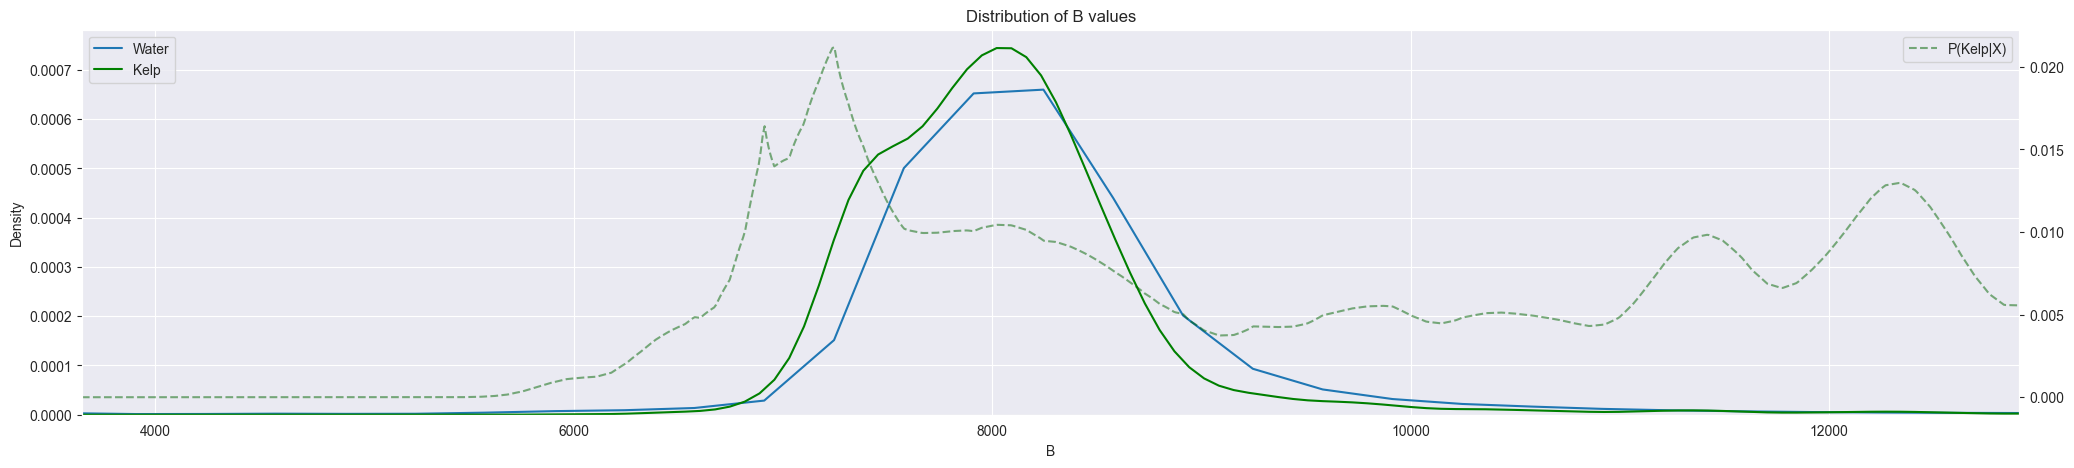

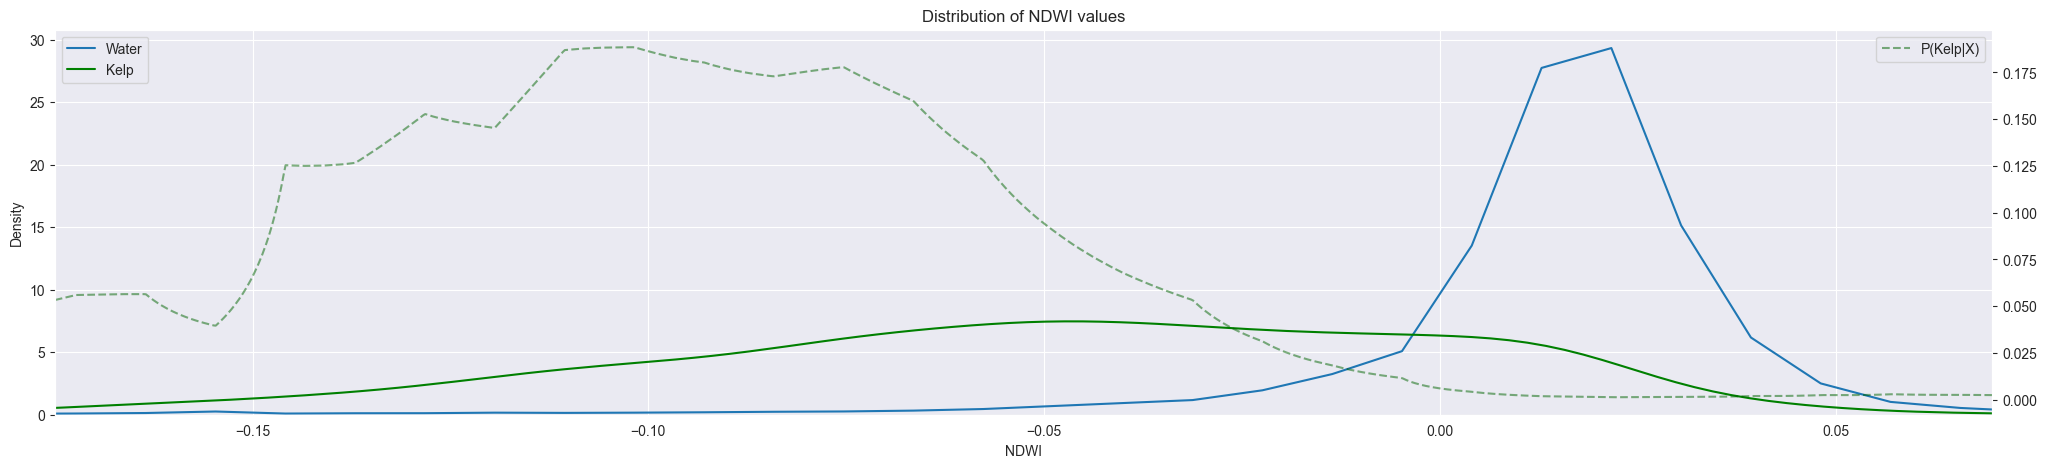

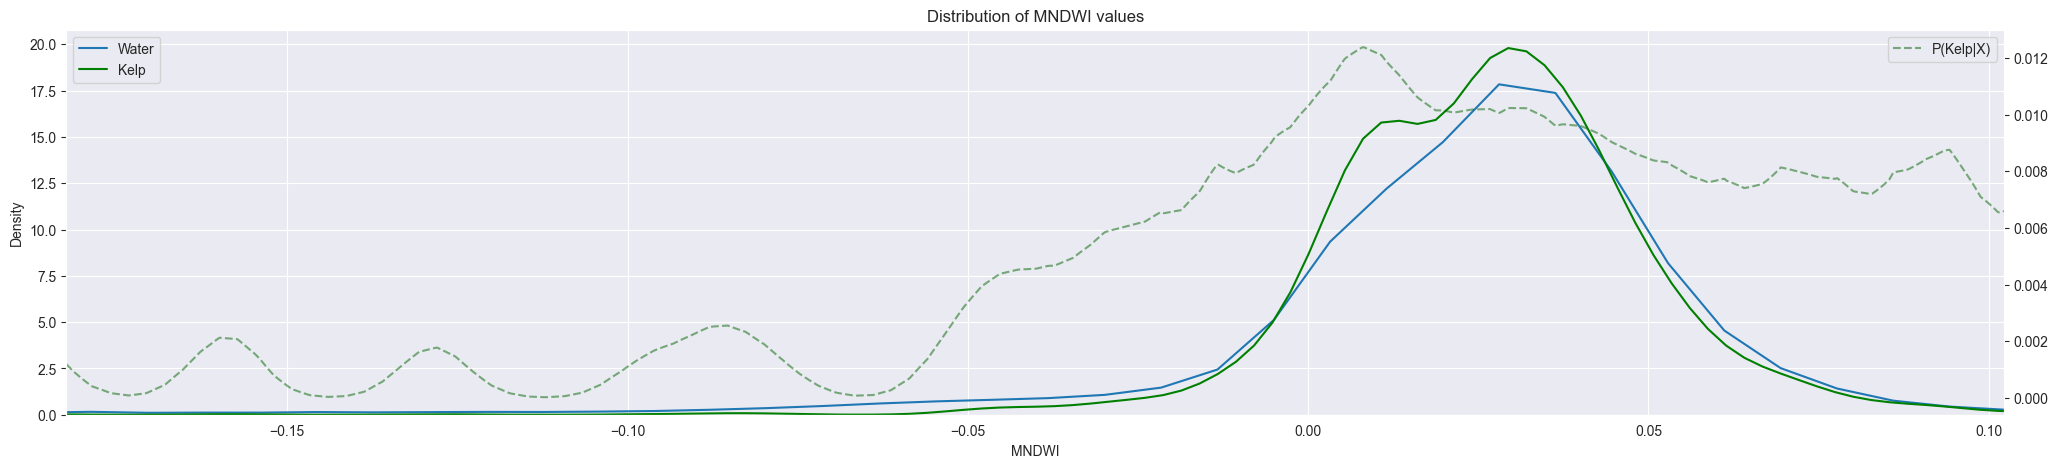

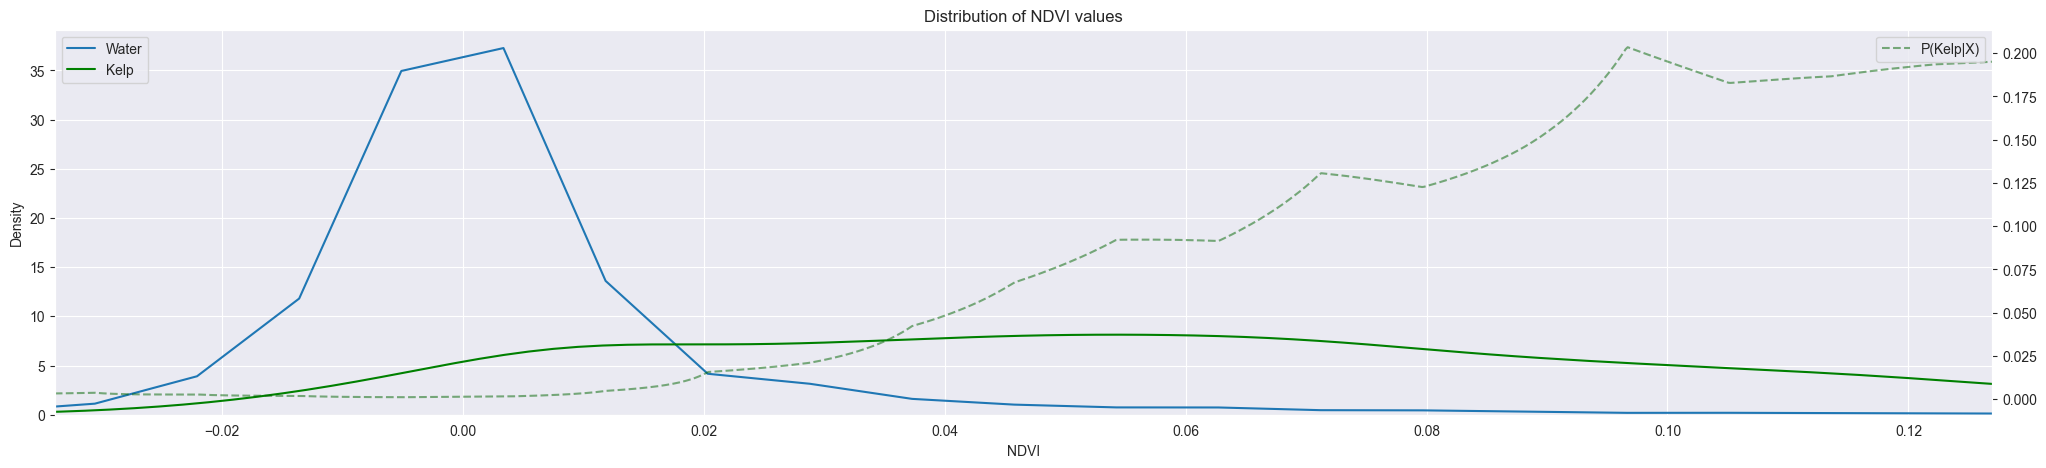

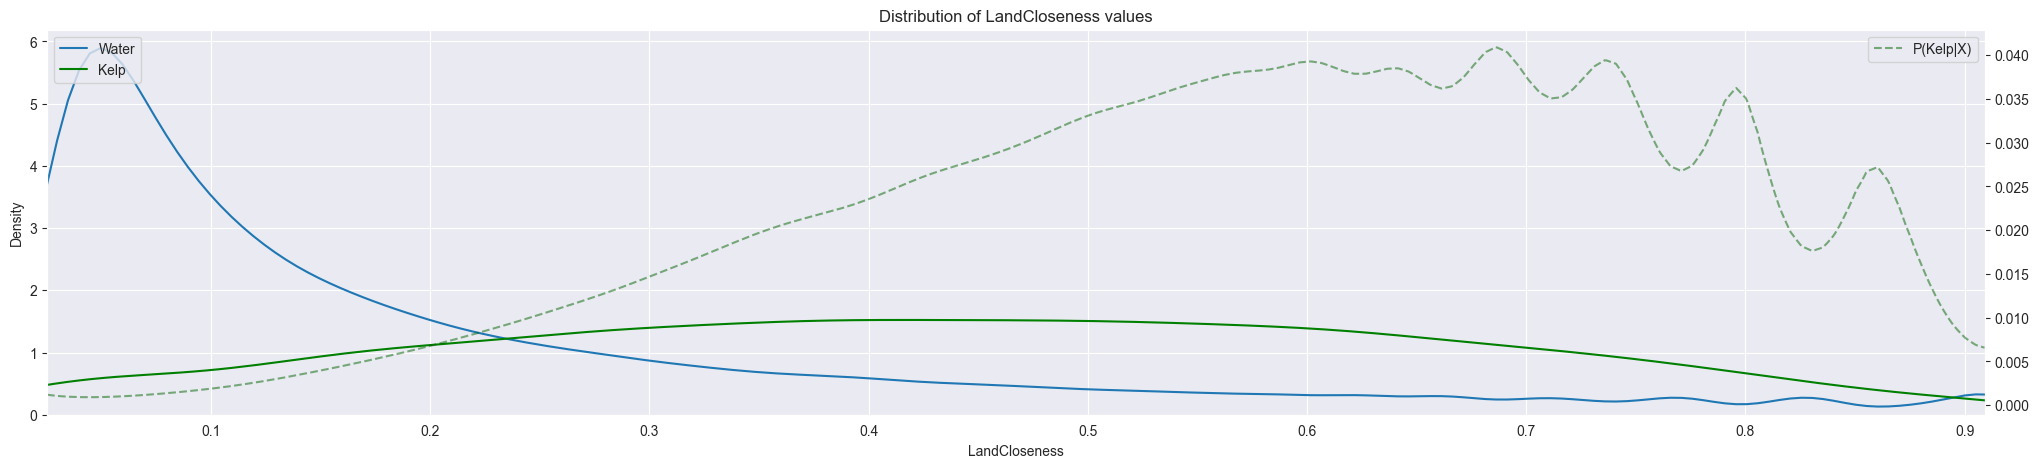

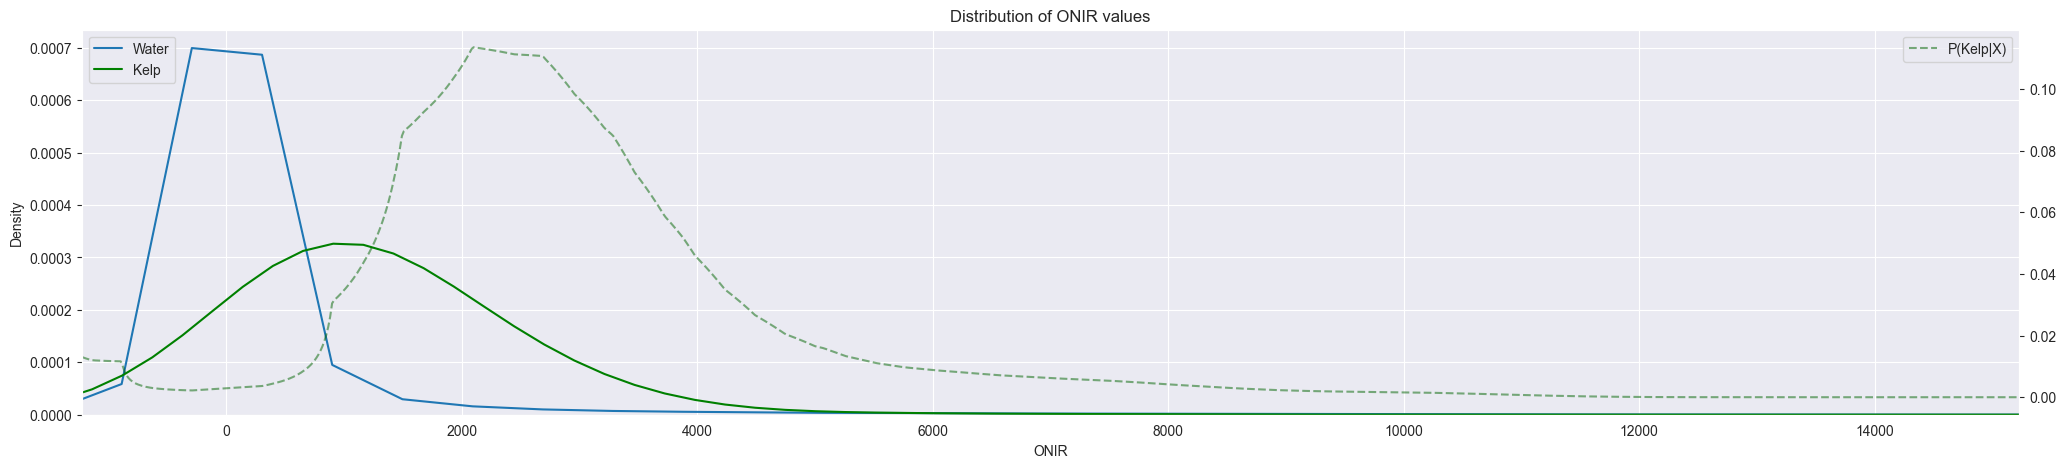

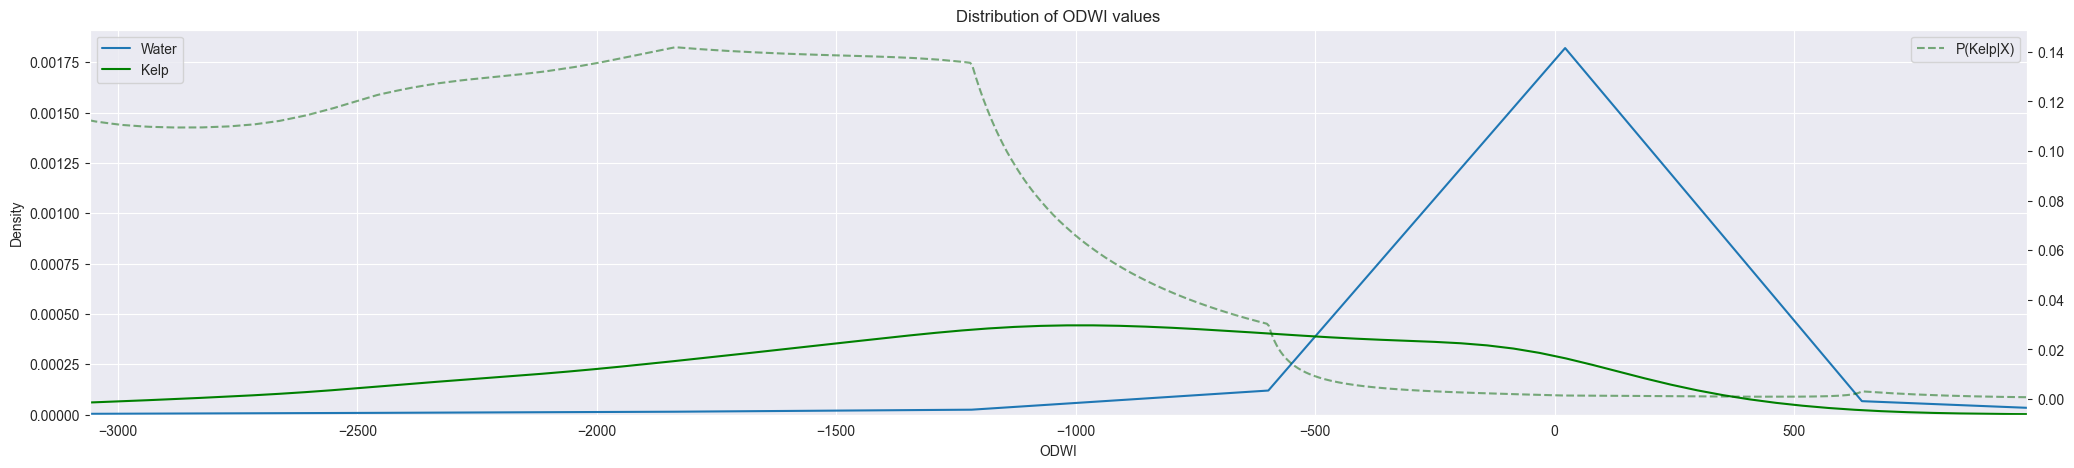

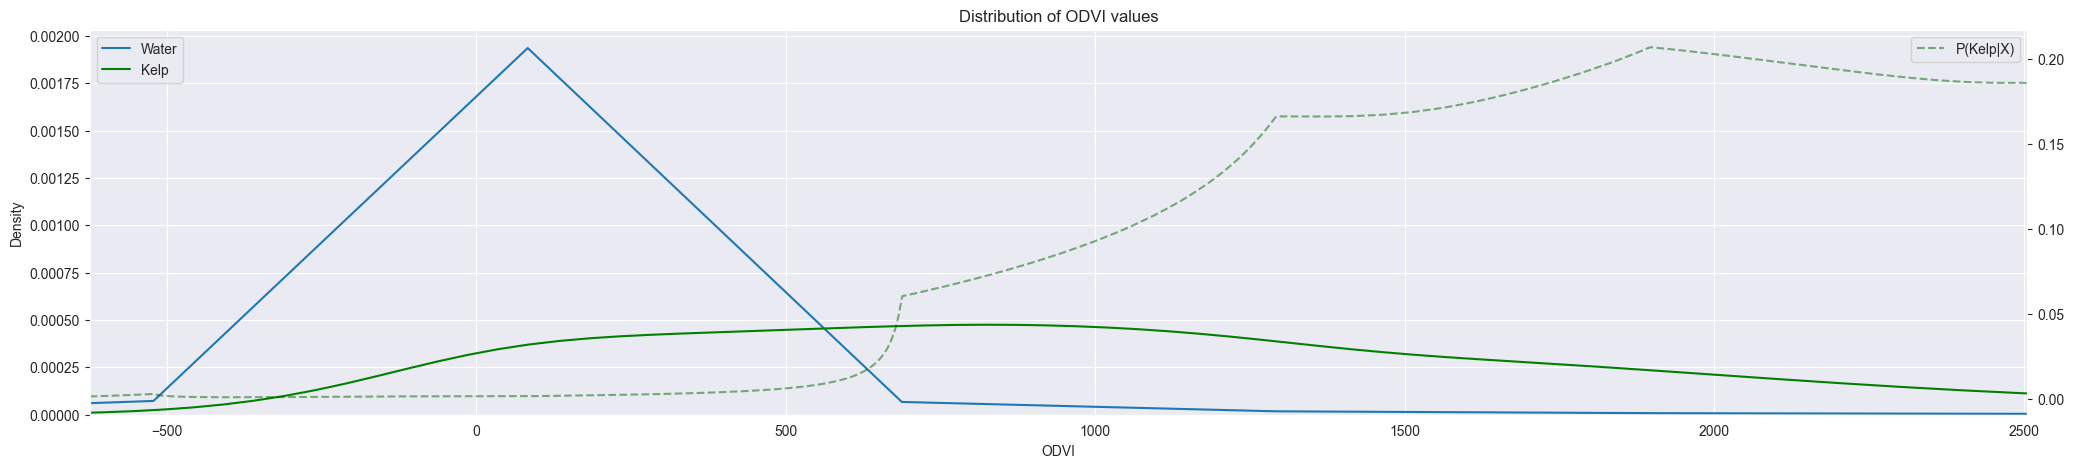

In [20]:
def interpolate(x,y):
    """Given x and y, return a function that gives the interpolated value at any point."""
    return scipy.interpolate.interp1d(x, y, kind='linear', fill_value='extrapolate')

cond_probs = dict()

# For each feature plot the distribution of values for water, kelp and land
for feature in tqdm(df.columns):
    if feature in ['Cloud', 'Elevation','Water','Label']:
        continue
    
    # subsample and filter on water pixels without missing values
    dfs = df[::750]
    dfs = dfs[dfs['Water'] & (dfs['R']>=0) & (dfs['G']>=0) & (dfs['B']>=0) & (dfs['NIR']>=0) & (dfs['SWIR']>=0)]
    
    # Create a figure and axes
    fig, ax = plt.subplots(figsize=(25, 5))
    
    # set the x-axis limits to percentiles 1 and 99
    ax.set_xlim(dfs[feature].quantile(0.01), dfs[feature].quantile(0.99))
    
    # Plot the kde for water pixels
    water = dfs[(dfs['Water'] == 1) & ~dfs['Label']][feature]
    plot = sns.kdeplot(water, label='Water', ax=ax, bw_adjust=1, warn_singular=False)
    
    # Plot the kde for kelp pixels
    kelp = dfs[dfs['Label'] == 1][feature]
    plot = sns.kdeplot(kelp, label='Kelp', ax=ax, bw_adjust=1, warn_singular=False, color='green')
    plt.legend(loc='upper left')
    
    # For the range, plot the probability of kelp, using bayes theorem on the KDEs
    kde_w = plot.lines[0].get_data()    
    kde_k = plot.lines[1].get_data()     
    x = np.linspace(*ax.get_xlim(), 1000)
    p_k = interpolate(kde_k[0], kde_k[1])(x) * len(kelp) / len(dfs)
    p_w = interpolate(kde_w[0], kde_w[1])(x) * len(water) / len(dfs)
    p_k_final = np.clip(p_k / (p_k + p_w), 0, np.inf)
    cond_probs[feature] = interpolate(x, p_k_final)
    ax2 = ax.twinx()
    ax2.plot(x, p_k_final, label='P(Kelp|X)', color='darkgreen', alpha=0.5, linestyle='--')
    ax2.grid(False)

    # Set the title and display the figure for this feature
    ax.set_title(f'Distribution of {feature} values')
    plt.legend()
    plt.show()


# Evaluating features
We can treat the conditional probabilities as a classifier, and evaluate the performance of each feature.
This is done on new images (the last N instead of first)

In [21]:
num = 1000
df_train = df
df_test = pd.concat([to_df(X_train[-i], y_train[-i]) for i in tqdm(range(1, num+1))])[::10]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

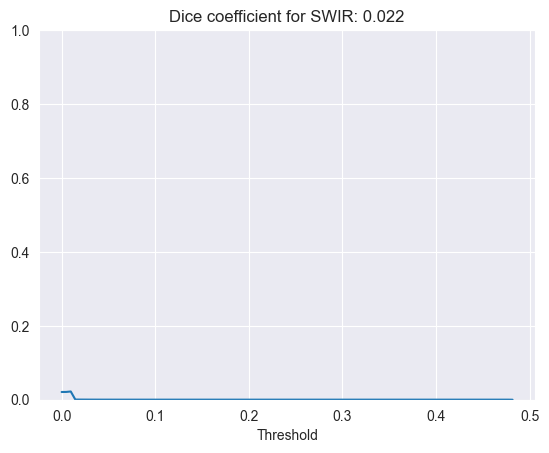

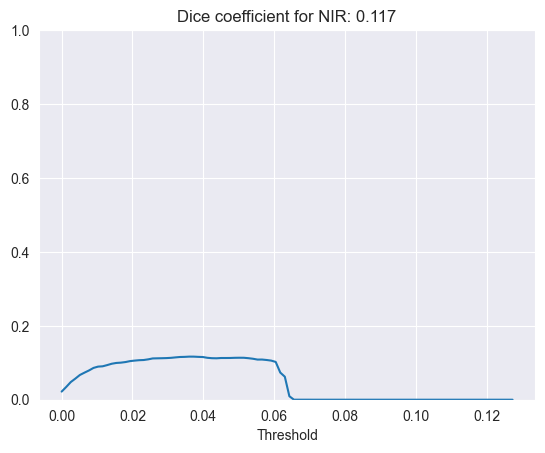

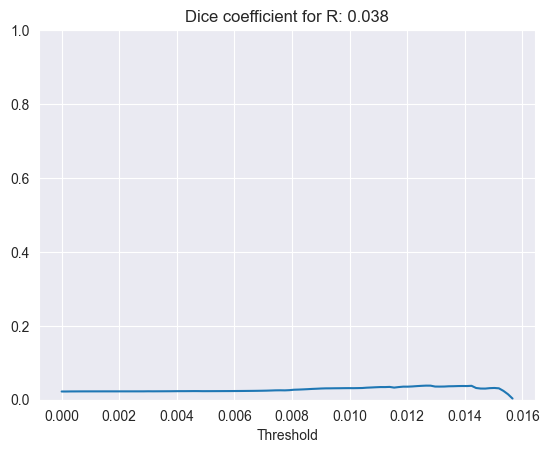

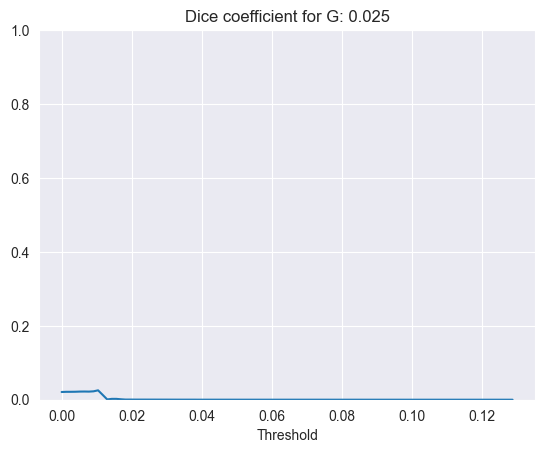

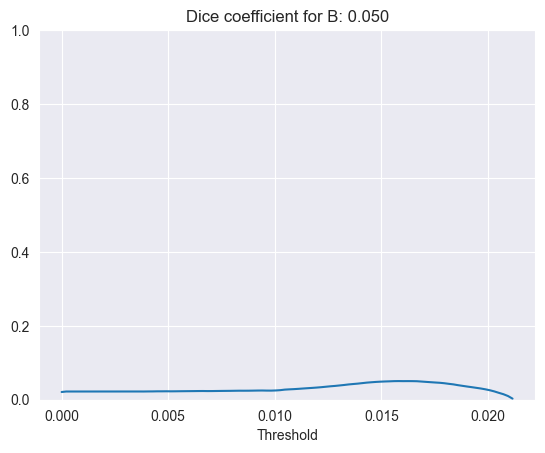

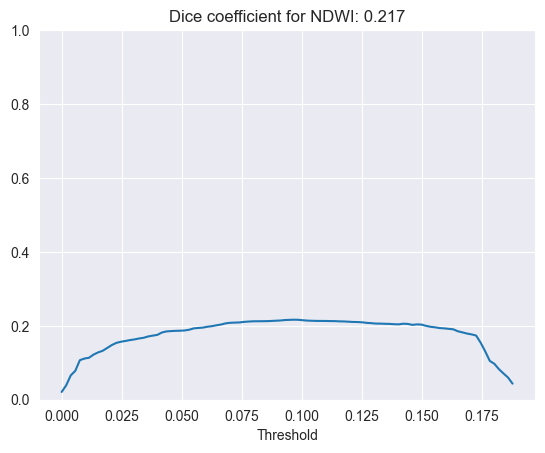

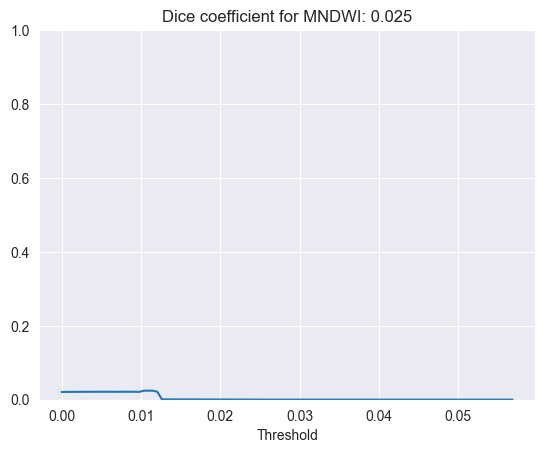

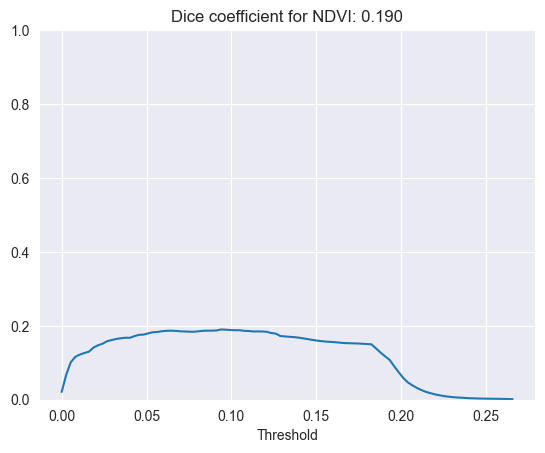

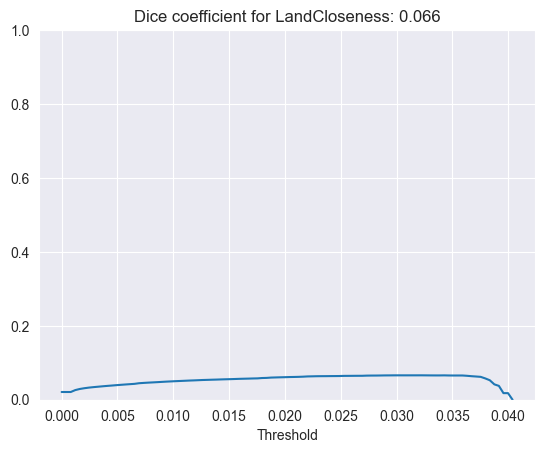

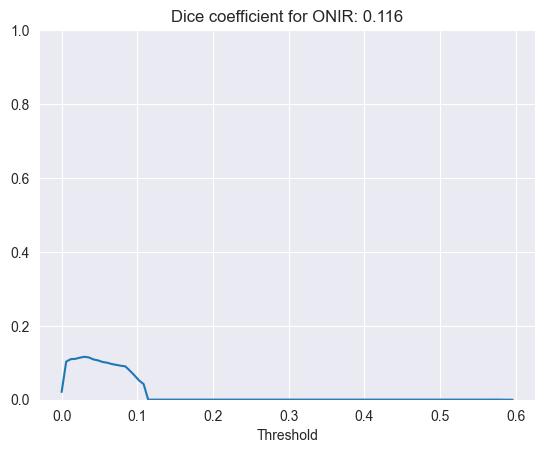

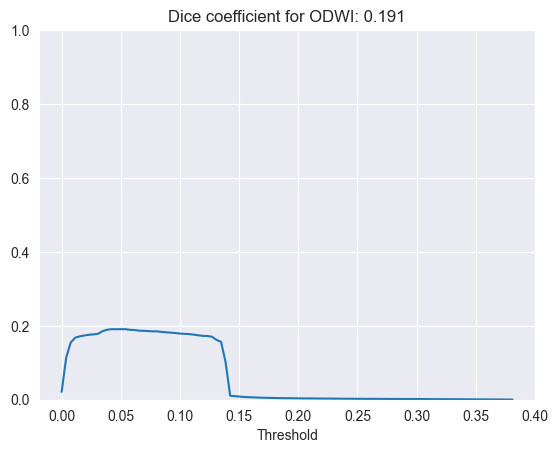

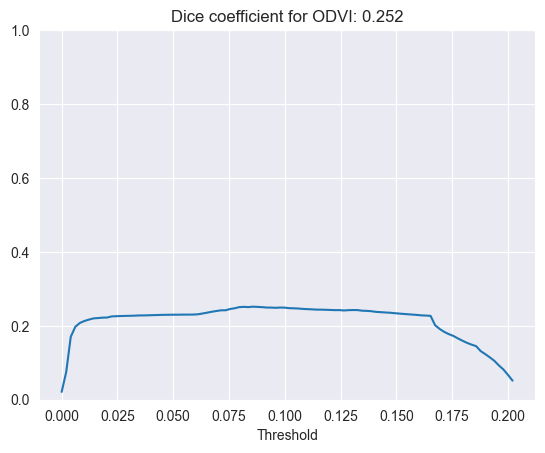

In [22]:
def eval_pred(pred, y, plot_name):
    """Compute the dice coefficient for a given feature."""    
    
    # Compute the dice coefficient for multiple thresholds
    dices = []
    max_thresh = np.percentile(pred, 99.9)
    for thresh in np.linspace(0, max_thresh, 100):
        pred_bin = pred > thresh
        intersection = (pred_bin & y).sum()
        dice = 2 * intersection / (pred_bin.sum() + y.sum())
        dices.append(dice)
        
    # plot the dice vs threshold with sns
    sns.lineplot(x=np.linspace(0, max_thresh, 100), y=dices)
    plt.title(f'Dice coefficient for {plot_name}: {max(dices):.3f}')
    plt.xlabel('Threshold')
    plt.ylim(0, 1)
    plt.show()   
    
    return max(dices)

# Evaluate the performance of each feature
feat_scores = dict()
for feature in tqdm(df.columns):
    if feature not in cond_probs:
        continue
    pred = cond_probs[feature](df_test[feature])
    pred[~df_test['Water']] = 0        
    dice = eval_pred(pred, df_test['Label'], feature)
    feat_scores[feature] = dice
    

From testing it was found that for a single feature, kde with bayes rules gave better predictors than catboost. However, catboost can be used to combine multiple features.
First, a naive approach combines the conditional probabilities by multiplication. This would be theoretically correct if the features were independent, but this is not the case.

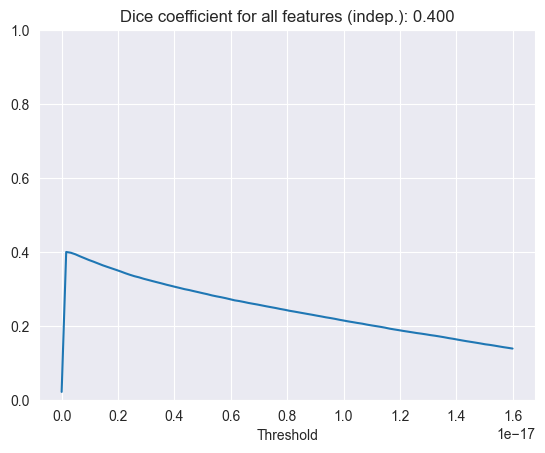

Learning rate set to 0.5
0:	learn: 0.3193200	test: 0.3215223	best: 0.3215223 (0)	total: 56.1s	remaining: 1h 32m 32s
1:	learn: 0.1764563	test: 0.1817417	best: 0.1817417 (1)	total: 1m 22s	remaining: 1h 7m 19s
2:	learn: 0.1082362	test: 0.1114270	best: 0.1114270 (2)	total: 1m 38s	remaining: 53m 19s
3:	learn: 0.0723824	test: 0.0728883	best: 0.0728883 (3)	total: 1m 51s	remaining: 44m 26s
4:	learn: 0.0488157	test: 0.0510663	best: 0.0510663 (4)	total: 2m 5s	remaining: 39m 35s
5:	learn: 0.0370758	test: 0.0385952	best: 0.0385952 (5)	total: 2m 15s	remaining: 35m 30s
6:	learn: 0.0293015	test: 0.0311543	best: 0.0311543 (6)	total: 2m 26s	remaining: 32m 31s
7:	learn: 0.0246973	test: 0.0269731	best: 0.0269731 (7)	total: 2m 38s	remaining: 30m 19s
8:	learn: 0.0218192	test: 0.0245461	best: 0.0245461 (8)	total: 2m 50s	remaining: 28m 39s
9:	learn: 0.0208782	test: 0.0233738	best: 0.0233738 (9)	total: 3m 1s	remaining: 27m 16s
10:	learn: 0.0235827	test: 0.0240905	best: 0.0233738 (9)	total: 3m 13s	remaining: 2

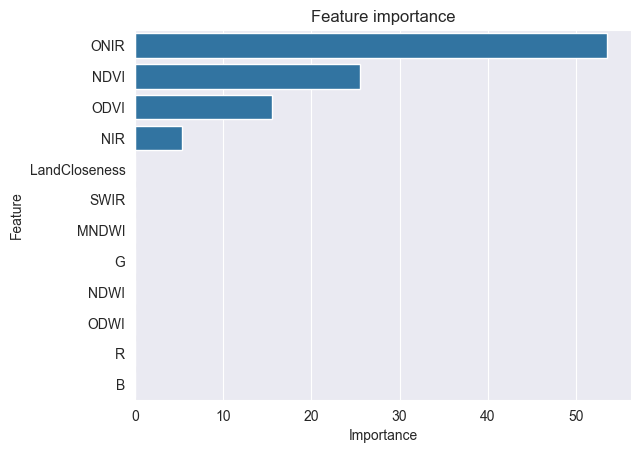

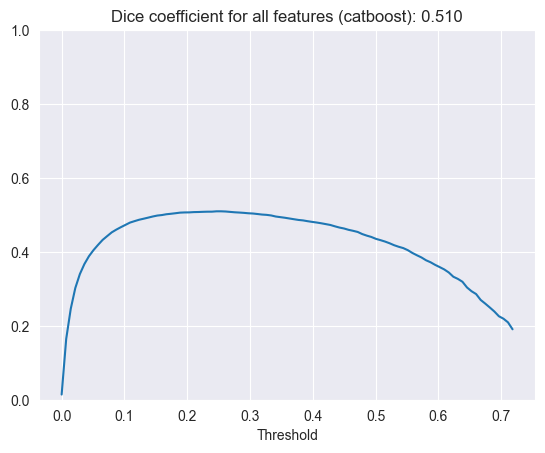

In [29]:
def fit_transform(df_train, df_test, features):
    """Fit a catboost model on the training data and return the predictions on the test data. Uses early stopping."""
    import catboost
    model = catboost.CatBoostClassifier(iterations=100, verbose=True, early_stopping_rounds=10)
    x_train = df_train[features].values.reshape(-1, len(features))
    y_train = df_train['Label']
    x_test = df_test[features].values.reshape(-1, len(features))
    y_test = df_test['Label']
    model.fit(x_train, y_train, verbose=True, eval_set=(x_test, y_test))
    
    # plot feature importances
    feat_scores = pd.DataFrame.from_dict(
        dict(zip(features, model.feature_importances_)),
        orient='index', columns=['Importance'])
    feat_scores.sort_values('Importance', inplace=True, ascending=False)
    sns.barplot(x='Importance', y=feat_scores.index, data=feat_scores)
    plt.ylabel('Feature')
    plt.title('Feature importance')
    plt.show()
    
    # save model
    model.save_model('catboost_model.cbm')
    # save names of features along with it for later reference
    with open('catboost_features.txt', 'w') as f:
        f.write('\n'.join(features))
    
    return model.predict_proba(x_test)[:, 1]

# Compute the performance when all features are used
cum_prob = np.ones(len(df_test))
cum_prob[~df_test['Water']] = 0     
for feature in cond_probs:
    cum_prob *= cond_probs[feature](df_test[feature])
dice = eval_pred(cum_prob, df_test['Label'], 'all features (indep.)')
feat_scores['All features (indep.)'] = dice

# Use all features with catboost
feats = list(cond_probs.keys())
pred = fit_transform(df_train, df_test, feats)
dice = eval_pred(pred, df_test['Label'], 'all features (catboost)')
feat_scores['All features (catboost)'] = dice

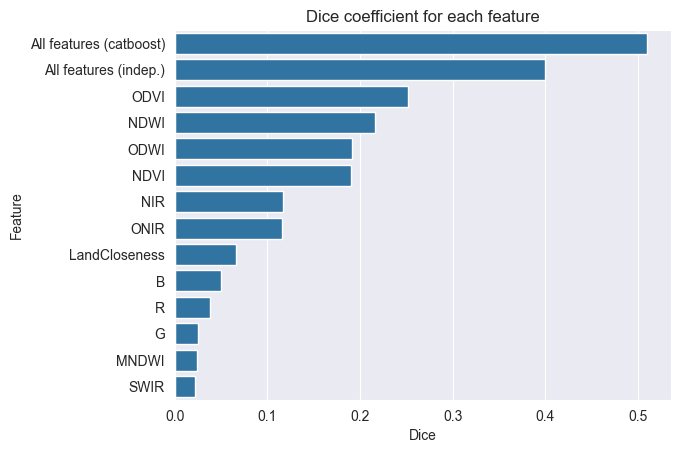

In [24]:
# Plot a barchart of the feature scores with sns
feat_scores_df = pd.DataFrame.from_dict(feat_scores, orient='index', columns=['Dice'])
feat_scores_df.sort_values('Dice', inplace=True, ascending=False)
sns.barplot(x='Dice', y=feat_scores_df.index, data=feat_scores_df)
plt.ylabel('Feature')
plt.title('Dice coefficient for each feature')
plt.show()